3月17号下午讨论会上王晨展示的散点图的清晰轮廓引起了大家的兴趣。这里检验一下这些轮廓是否与数据噪声和画图的方式有关。

可以归结为下面这个式子
$$R = \frac{x}{x/r+\delta}.$$
其中，$x$代表$^{12}$CO的强度，$r$表示$^{12}$CO与$^{13}$CO的内禀强度比，$\delta$表示随机噪声，$R$表示通过观测数据算出的比值。可以注意到以下几个方面：

1. 由于分母里噪声项$\delta$的存在，注意到$\delta$可以是负数，导致可以出现**比内禀比值$r$大很多**的比值。
1. 当$^{12}$CO的强度比较小时，$^{13}$CO的强度也会很小，观测灵敏度导致的数据点选取造成了左边的包络线。这条包络线的函数形式是$R = x / \sigma$，这里$\sigma$是画图时设置的噪声阈值。
1. 当$^{12}$CO的强度比较大时，$^{13}$CO的强度也会比较大，此时$^{13}$CO数据里的噪声相对而言不重要，也就不会出现因为噪声导致的很大的比值。这是右边包络线的成因。
1. 左边包络线会比右边包络线轮廓清晰，这是因为左边包络线是由一个确定的阈值给出的，而右边包络线与噪声的分布函数有关，会有明显的弥散。

下面的代码简单地模拟了上述情况，给出的图与观测数据相应的图比较像。所以，**似乎不需要引入化学和物理机制也能解释左右两边的轮廓。**

这也提示，当计算较强信号与较弱信号的比值时，较弱信号的信噪比一定要比较高才有意义。尚不清楚文献里的其它工作是否收到这类因素的影响。

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


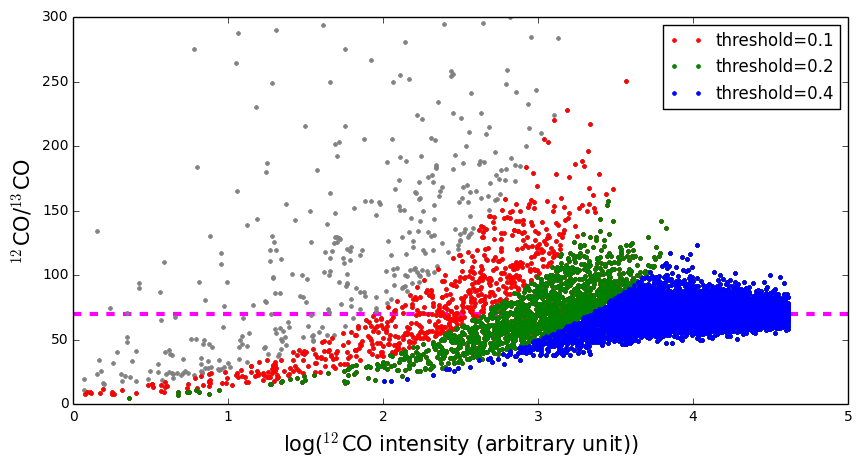

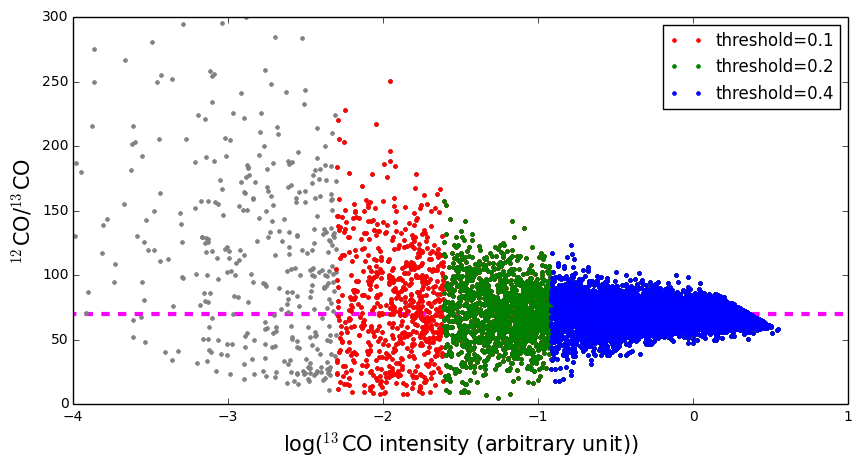

In [2]:
n = 10000

x = rand(n) * 100 + 1

r = 70

noise = randn(n) * 0.1

y = x / r + noise
ratio = x / y

figure(figsize=(10,5))

plot(log(x), ratio, ls='', marker='.', color='gray')
ax = gca()
ax.set_xlabel('log($^{12}$CO intensity (arbitrary unit))', fontsize=15)
ax.set_ylabel('$^{12}$CO/$^{13}$CO', fontsize=15)
ax.set_ylim((0, 300))
ax.hlines(r, 0, 5, colors='magenta', lw=3, linestyles='dashed')

for thres,col in zip([0.1, 0.2, 0.4], ['red', 'green', 'blue']):
    # 不同颜色表示不同阈值
    idx = where(y > thres)
    plot(log(x[idx]), ratio[idx], ls='', marker='.',
         color=col, label='threshold={t}'.format(t=thres))

_ = ax.legend()

# 以13CO强度为横坐标重画
figure(figsize=(10,5))
y = ma.masked_less(y, 0)
plot(ma.log(y), ratio, ls='', marker='.', color='gray')
ax = gca()
ax.set_xlabel('log($^{13}$CO intensity (arbitrary unit))', fontsize=15)
ax.set_ylabel('$^{12}$CO/$^{13}$CO', fontsize=15)
ax.set_xlim((-4, 1))
ax.set_ylim((0, 300))
ax.hlines(r, -5, 5, colors='magenta', lw=3, linestyles='dashed')

for thres,col in zip([0.1, 0.2, 0.4], ['red', 'green', 'blue']):
    # 不同颜色表示不同阈值
    idx = where(y > thres)
    plot(ma.log(y[idx]), ratio[idx], ls='', marker='.',
         color=col, label='threshold={t}'.format(t=thres))

_ = ax.legend()

# 2019-05-11更新

---
### 结论

如果希望研究丰度比随柱密度的变化，应该先对柱密度分段，找出每段内两种分子各自的平均强度，然后再相除。

在下面的例子中，把柱密度分成了十段，可以看到，数据噪声不大时 (蓝线和红线)，趋势很清楚。

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def ratio_plot(ax, x, y1, y2, th=0, color='gray', lw=3):
    idx = np.where(y2>th)
    ax.plot(x[idx], y1[idx]/y2[idx], ls='none', marker='.',
            markersize=1, color=color)
    nx = x.size
    step = nx//10
    xnew = []
    ynew=[]
    for i in range(0,nx-1,step):
        xnew.append(np.mean(x[i:i+step]))
        ynew.append(np.mean(y1[i:i+step]) / np.mean(y2[i:i+step]))
    ax.plot(xnew, ynew, lw=lw, color=color, zorder=100)

## 模拟比值为常数的情形

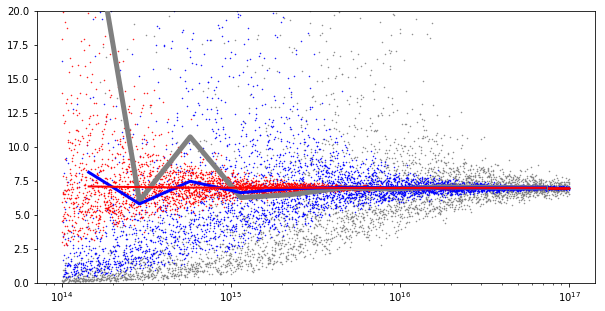

In [7]:
n = 5000
x = np.logspace(14,17,num=n)
IntT = x/1e15
r = 7

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_xscale('log')
ax.set_ylim((0,20))

ratio_plot(ax, x, IntT, IntT/r + np.random.normal(scale=0.5, size=n),
           th=0.0, color='gray', lw=5)
ratio_plot(ax, x, IntT, IntT/r + np.random.normal(scale=0.1, size=n),
           th=0.0, color='blue', lw=3)
ratio_plot(ax, x, IntT, IntT/r + np.random.normal(scale=0.01, size=n),
           th=0.0, color='red', lw=2)

## 模拟比值是柱密度的线性函数的情形

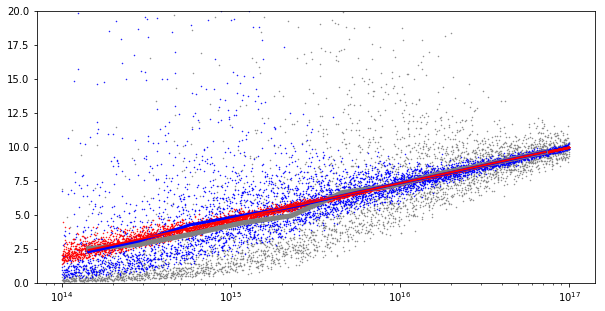

In [8]:
n = 5000
x = np.logspace(14,17,num=n)
IntT = x/1e15
r = np.linspace(2,10,num=n)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_xscale('log')
ax.set_ylim((0,20))

ratio_plot(ax, x, IntT, IntT/r + np.random.normal(scale=0.5, size=n),
           th=0.0, color='gray', lw=5)
ratio_plot(ax, x, IntT, IntT/r + np.random.normal(scale=0.1, size=n),
           th=0.0, color='blue', lw=3)
ratio_plot(ax, x, IntT, IntT/r + np.random.normal(scale=0.01, size=n),
           th=0.0, color='red', lw=2)

---


**下面是比较复杂的尝试，不必阅读。**

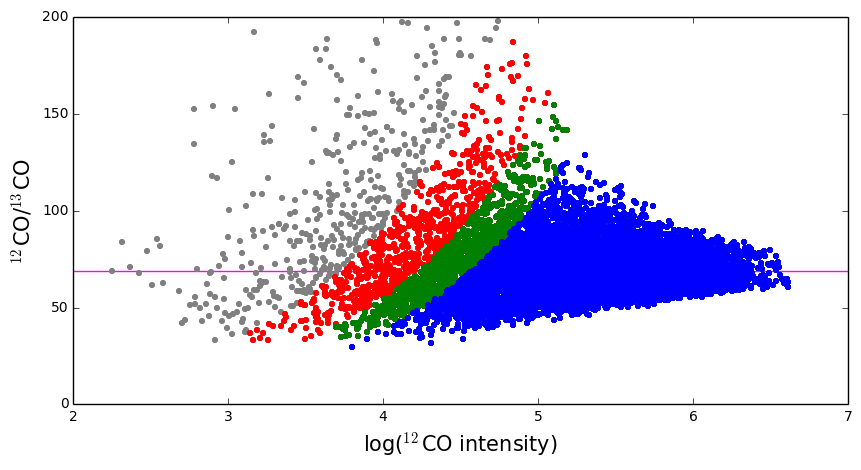

In [3]:
n = 10000

T_12 = random.beta(2, 3, size=n)*50 + 4

dV_12 = random.beta(2, 2, size=n)*15 + 1

I_12CO = T_12 * dV_12

ratio_T_12_to_13 = 69

dV_ratio = 1.0

T_13 = T_12 / ratio_T_12_to_13 + (rand(n) - 0.5) * 0.2
dV_13 = dV_12 / dV_ratio

I_13CO = T_13 * dV_13
ratio_12_to_13 = I_12CO / I_13CO

figure(figsize=(10,5))

plot(log(I_12CO), ratio_12_to_13, label='No threshold', markeredgewidth=0,
     marker='.', markersize=10,
     color='gray', linestyle='')

ax = gca()
ax.set_xlabel('log($^{12}$CO intensity)', fontsize=15)
ax.set_ylabel('$^{12}$CO/$^{13}$CO', fontsize=15)
ax.set_xlim((2, 7))
ax.set_ylim((0, 200))
ax.hlines(ratio_T_12_to_13, 0, 10, colors='magenta')

# 下面用不同颜色画出采用不同13CO截断后的散点图
for thres,col in zip([0.6, 1, 1.4], ['red', 'green', 'blue']):
    index_above_threshold = where(I_13CO > thres)
    ax.plot(log(I_12CO[index_above_threshold]),
            ratio_12_to_13[index_above_threshold],
            marker='o', markersize=5,
            markeredgewidth=0, linestyle='', color=col)

(array([  361.,  1072.,  1378.,  1312.,  1141.,  1081.,   888.,   739.,
          565.,   416.,   336.,   259.,   161.,   108.,    91.,    38.,
           22.,    14.,    11.,     7.]),
 array([   7.12729783,   44.04142973,   80.95556163,  117.86969353,
         154.78382543,  191.69795733,  228.61208923,  265.52622113,
         302.44035303,  339.35448493,  376.26861683,  413.18274873,
         450.09688063,  487.01101253,  523.92514443,  560.83927633,
         597.75340823,  634.66754013,  671.58167203,  708.49580393,
         745.40993583]),
 <a list of 20 Patch objects>)

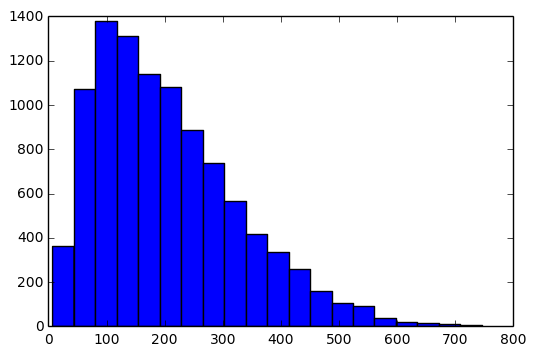

In [4]:
hist(I_12CO, bins=20)

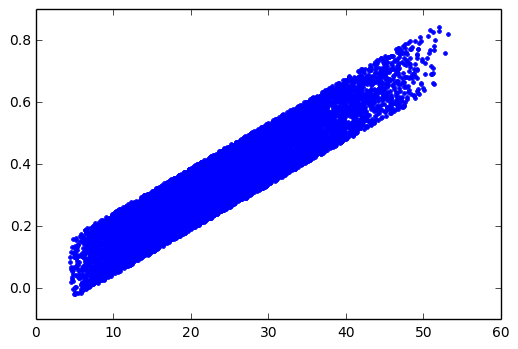

In [5]:
plot(T_12, T_13, ls='', marker='.')

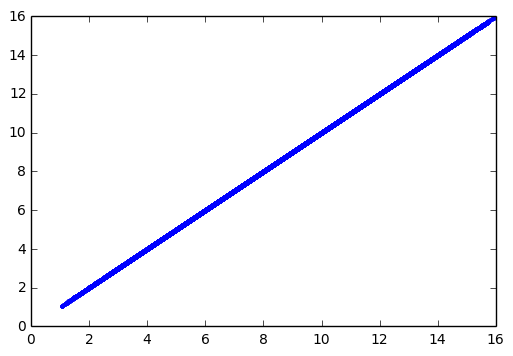

In [6]:
plot(dV_12, dV_13, ls='', marker='.')

(3, 6.5)

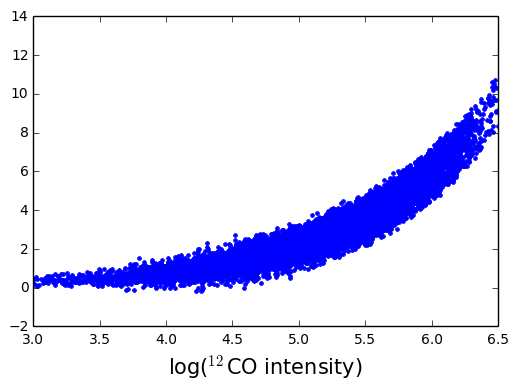

In [7]:
plot(log(I_12CO), I_13CO, ls='', marker='.')
ax = gca()
ax.set_xlabel('log($^{12}$CO intensity)', fontsize=15)
ax.set_xlim((3,6.5))

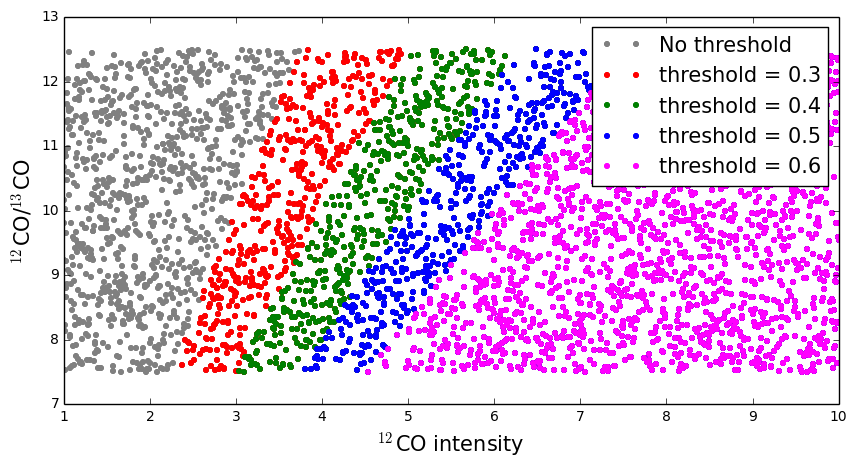

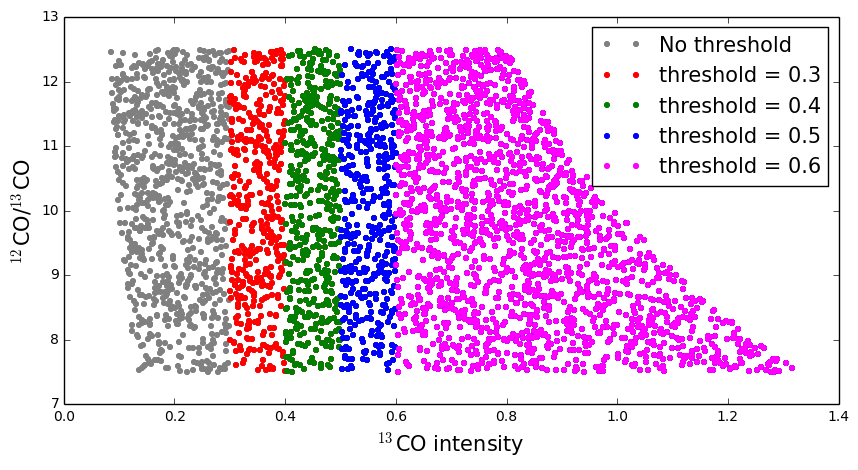

In [8]:
n = 4000 # 随机点的个数，对应于观测数据的总点数 (被筛选之前)

ratio_12_to_13_mean = 10 # 假定 12CO/13CO 比值的平均值是 10 (只是数值实验，不一定符合实际)
ratio_var = 5 # 假定 12CO/13CO 比值的大致变化幅度是 5
ratio_12_to_13 = ratio_12_to_13_mean + ratio_var * (rand(n) - 0.5)

min_12, max_12 = 1, 10 # 假定的 12CO 强度范围，arbitrary unit
I_12CO = linspace(min_12, max_12, num=n)
I_13CO = I_12CO / ratio_12_to_13 # 13CO 强度

figure(figsize=(10,5))

_ = plot(I_12CO, ratio_12_to_13, label='No threshold', markeredgewidth=0,
         marker='.', markersize=10,
         color='gray', linestyle='')
ax = gca()
ax.set_xlabel('$^{12}$CO intensity', fontsize=15)
ax.set_ylabel('$^{12}$CO/$^{13}$CO', fontsize=15)

# 下面用不同颜色画出采用不同13CO截断后的散点图
for thres,col in zip([0.3, 0.4, 0.5, 0.6], ['red', 'green', 'blue', 'magenta']):
    index_above_threshold = where(I_13CO > thres)
    ax.plot(I_12CO[index_above_threshold],
            ratio_12_to_13[index_above_threshold],
            marker='o', markersize=5, label='threshold = {t}'.format(t=thres),
            markeredgewidth=0, linestyle='', color=col)
_ = ax.legend(fontsize=15)


figure(figsize=(10,5))

_ = plot(I_13CO, ratio_12_to_13, label='No threshold', markeredgewidth=0,
         marker='.', markersize=10,
         color='gray', linestyle='')
ax = gca()
ax.set_xlabel('$^{13}$CO intensity', fontsize=15)
ax.set_ylabel('$^{12}$CO/$^{13}$CO', fontsize=15)

# 下面用不同颜色画出采用不同13CO截断后的散点图
for thres,col in zip([0.3, 0.4, 0.5, 0.6], ['red', 'green', 'blue', 'magenta']):
    index_above_threshold = where(I_13CO > thres)
    ax.plot(I_13CO[index_above_threshold],
            ratio_12_to_13[index_above_threshold],
            marker='o', markersize=5, label='threshold = {t}'.format(t=thres),
            markeredgewidth=0, linestyle='', color=col)
_ = ax.legend(fontsize=15)